© 2025 Zitao Yang, Rebecca J. Rousseau, Sara D. Mahdavi, Hernan G. Garcia, and Rob Phillips, *The Dynamics of Inducible Genetic Circuits*. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).
___

# Regimes of Bistability in Auto-Activation

This notebook generates the results in Figure 11 and its corresponding supplementary Figure 28 in Appendix B of the paper. These figures determine the range of effector concentrations for which the system exhibits bistability, tuning the (A) cooperativity $\omega$, and the mRNA expression rates (B) $r_{0}$, (C) $r_{1}$, and (D) $r_{2}$.

## Formatting and parameters

In [3]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import math
from matplotlib import cm
from matplotlib.colors import Normalize

In [4]:
# fixed parameters for inducer function
delE=4.5
Ka=1.4*10**(-4)
Ki=5.3*10**(-7)
K_c=Ka/Ki

# Define fixed parameters
fixed_r0 = 0.1
fixed_r1 = 1
fixed_r2 = 20
fixed_w = 7

#plotting parameters
size_legend_axis = 15
size_label_axis_y = 30
size_label_axis_x = 20

## Helper functions

In [6]:
def pAct(c, Ka=Ka, Ki=Ki, delE=delE):
    """ probability of repressor/activator being active

    Parameters:
        - c: effector concentration
        - Ka: dissociation constant for active state
        - Ki: dissociation constant for inactive state
        - delE: energy difference between inactive and active state
    """
    p= (1 + c)**2 / ((1 + c)**2 + np.exp(-delE)*(1 + c*K_c)**2)
    return p

In [7]:
def polynomial_coefficients(pact, w, r0, r1, r2):
    """ Define an array containing the coefficients of the polynomial generated 
    from setting the auto-activation dynamical equation equal to zero
    to solve for steady states

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    return [w * pact**2,
            (2 * pact - w * r2 * pact**2),
            (1 - 2 * r1 * pact),
            -r0]

# Function to find roots for varying pact
def find_real_positive_roots(pact, w, r0, r1, r2):
    """ Calculate real positive roots for the polynomial steady state condition,
    varying pact

    Parameters:
        - pact: probability of A being active
        - w: cooperativity
        - r0: r_0, basal rate of activator mRNA expression, i.e., expression rate
          for unbound regulatory state (dimensionless)
        - r1: r_1, rate of activator mRNA expression in regulatory state with
          one bound activator (dimensionless)
        - r2: r_2, rate of activator mRNA expression in regulatory state with
          two bound activators (dimensionless)
    """
    coeffs = polynomial_coefficients(pact, w, r0, r1, r2)
    roots = np.roots(coeffs)
    # Filter for real and positive roots
    real_positive_roots = roots[np.isreal(roots) & (roots > 0)]
    return real_positive_roots

def parameters(pact, val, param_to_sweep, fixed_w, fixed_r0, fixed_r1, fixed_r2):
  """ Depending on which parameter we are interested in sweeping, output the relevant parameter values,
  specifying the sweep parameter value and the remaining parameters at preset fixed values

  Parameters:
      - pact: probability of A being active
      - val: value of sweeped parameter
      - param_to_sweep: choice of parameter to sweep, i.e., 'w', etc.
      - fixed_w: fixed default value for cooperativity
      - fixed_r0: fixed default value for rate r0
      - fixed_r1: fixed default value for rate r1
      - fixed_r2: fixed default value for rate r2
  """
  if param_to_sweep=='w':
    return [pact, val, fixed_r0, fixed_r1, fixed_r2]

  if param_to_sweep=='r0':
    return [pact, fixed_w, val, fixed_r1, fixed_r2]

  if param_to_sweep=='r1':
    return [pact, fixed_w, fixed_r0, val, fixed_r2]

  if param_to_sweep=='r2':
    return [pact, fixed_w, fixed_r0, fixed_r1, val]

In [8]:
def is_stable(A, pact, w, r0, r1, r2):
  """ Define stability at a given activator concentration and effector concentration

  Parameters:
      - A: dimensionless activator concentration
      - pact: probability of A being active
      - w: cooperativity
      - r0: value for rate r0 (dimensionless)
      - r1: value for rate r1 (dimensionless)
      - r2: value for rate r2 (dimensionless)
  """
  same_sign_than_fprime = (-1 + pact * (-4 * A * (1 + A * pact) - 2 * r0 + 2 * r1 -
                      2 * A * pact * (A + r0 + A * pact * (2 * A + r1 - r2) -
                      r2) * w - A**4 * pact**3 * w**2))
  if same_sign_than_fprime>0:
    return True
  else:
    return False

In [9]:
def stable_and_unstable_points(c_values, fixed_w, fixed_r0, fixed_r1, fixed_r2):
  """ Having calculated the steady states at each sampled effector concentration,
  determine whether the fixed points are stable or unstable

  Parameters:
      - c_values: sampled effector concentrations (M)
      - fixed_w: fixed default value for cooperativity
      - fixed_r0: fixed default value for rate r0
      - fixed_r1: fixed default value for rate r1
      - fixed_r2: fixed default value for rate r2
  """
  stable_points=[]
  unstable_points=[]
  for cval in c_values:
    pact=pAct(cval)
    real_pos_roots=find_real_positive_roots(pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
    for r in real_pos_roots:
      bool_stable = is_stable(r, pact, fixed_w, fixed_r0, fixed_r1, fixed_r2)
      if not bool_stable:
        stable_points +=[(cval, r)]
      else:
        unstable_points +=[(cval, r)]

  stable_points=np.array(stable_points)
  unstable_points=np.array(unstable_points)
  return stable_points, unstable_points

In [10]:
def c_bif_max(K_c, delE, w, r2):
    """ Determine the maximum effector concentration
    for which the auto-activation system is bistable
    
    Parameters:
      - K_c: ratio of dissociation constants for active vs. inactive states
      - delE: energy difference between inactive and active state
      - w: cooperativity
      - r2: rate r2
    """
    exp_neg_delE = np.exp(-delE)
    term1 = exp_neg_delE * K_c
    term2 = (w * r2) / 2 - 1
    sqrt_term = (exp_neg_delE * (1 + K_c)**2 * term2)**0.5
    numerator = term1 + (w * r2) / 2 - 1 + sqrt_term

    denominator = exp_neg_delE * K_c**2 - (w * r2) / 2 + 1

    return numerator / denominator

In [11]:
def c_bif_min(K_c, delE, r1):
    """ Determine the minimum effector concentration
    for which the auto-activation system is bistable
    
    Parameters:
      - K_c: ratio of dissociation constants for active vs. inactive states
      - delE: energy difference between inactive and active state
      - r1: rate r1
    """
    exp_neg_delE = np.exp(-delE)
    term1 = exp_neg_delE * K_c
    term2 = 2 * r1 - 1
    sqrt_term = (exp_neg_delE * (1 + K_c)**2 * term2)**0.5
    numerator = term1 + 2 * r1 - 1 + sqrt_term

    denominator = exp_neg_delE * K_c**2 - 2 * r1 + 1

    return numerator / denominator

In [12]:
def sweep(sweep_list, param_to_sweep, fixed_w, fixed_r0, fixed_r1, fixed_r2, c_values= np.logspace(-4, 2, 1000), K_c = K_c, delE = delE):
    """ For a given parameter sweep, as the sweep parameter increases we determine
    the corresponding minimum and maximum effector concentration for which the 
    auto-activation system is bistable
    
    Parameters:
      - sweep_list: sampled values of sweeped parameter
      - param_to_sweep: sweep parameter
      - fixed_w: fixed default value for cooperativity
      - fixed_r0: fixed default value for rate r0
      - fixed_r1: fixed default value for rate r1
      - fixed_r2: fixed default value for rate r2
      - c_values: sampled effector concentrations (M)
      - K_c: ratio of dissociation constants for active vs. inactive states
      - delE: energy difference between ianctive and active state
    """
    Cminbif_values = []
    Cmaxbif_values = []

    for val in sweep_list:
      c_bistable=[]
      for c in c_values:
        pact=pAct(c)
        params=parameters(pact, val, param_to_sweep, fixed_w, fixed_r0, fixed_r1, fixed_r2)
        roots = find_real_positive_roots(*params)
        if len(roots)==3:
          c_bistable+=[c]
      if len(c_bistable)>0:
        Cminbif_values.append(min(c_bistable))
        Cmaxbif_values.append(max(c_bistable))
      else:
        Cminbif_values.append(np.nan)
        Cmaxbif_values.append(np.nan)
    return np.array(Cminbif_values), np.array(Cmaxbif_values)

In [13]:
nn=2000
w_values = np.logspace(-6, 6, nn)   # Varying w
r0_values = np.logspace(-6,np.log10(fixed_r1), nn)  # Varying r0
r1_values = np.logspace(np.log10(fixed_r0),np.log10(fixed_r2), nn)  # Varying r1
r2_values = np.logspace(np.log10(fixed_r1),6, nn)  # Varying r2

In [14]:
Cminbif_values_sweep_w, Cmaxbif_values_sweep_w=sweep(w_values, 'w', fixed_w, fixed_r0, fixed_r1, fixed_r2, c_values= np.logspace(-2, 2, 1000))
Cminbif_values_sweep_r0, Cmaxbif_values_sweep_r0=sweep(r0_values, 'r0', fixed_w, fixed_r0, fixed_r1, fixed_r2, c_values= np.logspace(-2, 2, 1000))
Cminbif_values_sweep_r1, Cmaxbif_values_sweep_r1=sweep(r1_values, 'r1', fixed_w, fixed_r0, fixed_r1, fixed_r2, c_values= np.logspace(-2, 2, 1000))
Cminbif_values_sweep_r2, Cmaxbif_values_sweep_r2=sweep(r2_values, 'r2', fixed_w, fixed_r0, fixed_r1, fixed_r2, c_values= np.logspace(-2, 2, 1000))

# Fig. 11

This figure plots the numerical regions of bistability, demonstrating how the bistable regime of effector concentrations changes as a single cooperativity or rate parameter increases (keeping all other parameters fixed).

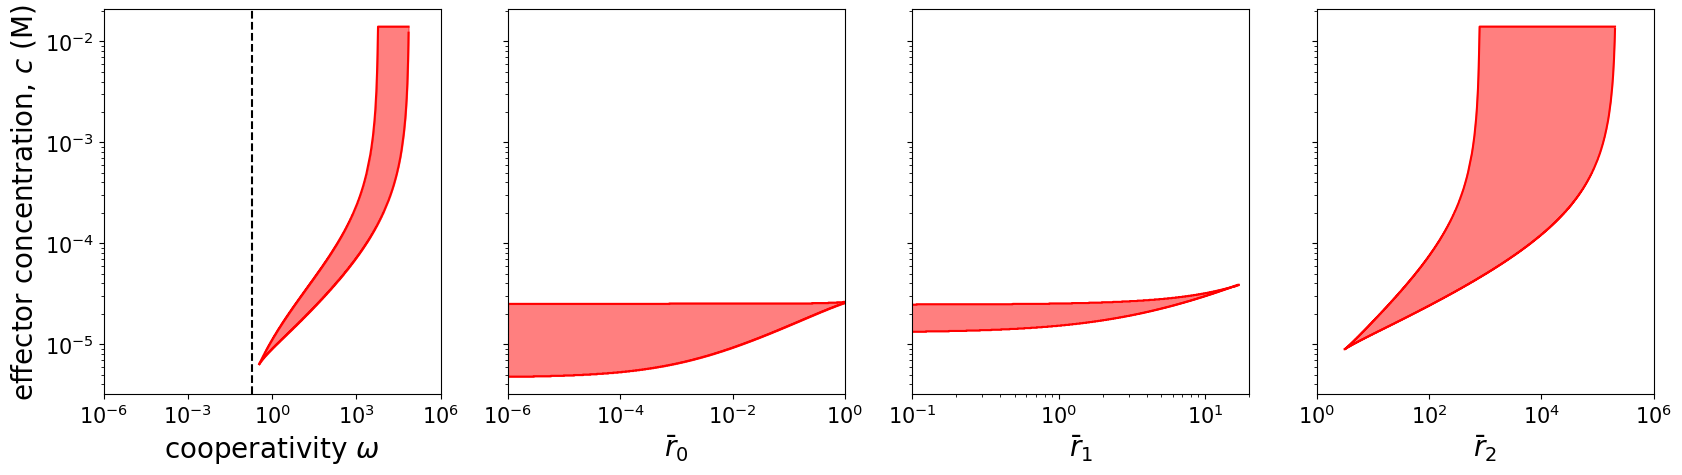

In [32]:
fig, axs = plt.subplots(1,4, sharey=True, figsize=(20, 5))

# omega

w_min_bifurcation = max(4*fixed_r1/ fixed_r2,2*(1+np.exp(-delE))/fixed_r2)

axs[0].plot(w_values, Ka*Cminbif_values_sweep_w, linewidth = 1.5, color = 'red')
axs[0].plot(w_values, Ka*Cmaxbif_values_sweep_w, linewidth = 1.5, color = 'red')
axs[0].fill_between(w_values, Ka*Cminbif_values_sweep_w , y2=Ka*Cmaxbif_values_sweep_w, color='red', alpha=0.5)
axs[0].axvline(w_min_bifurcation, linestyle='--', color='k', linewidth=1.5)


axs[0].tick_params(axis='both', which='both', labelsize = size_legend_axis )
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'effector concentration, $c$ (M)', fontsize = 20)
axs[0].set_xlabel(r'cooperativity $\omega$', fontsize = size_label_axis_x)
axs[0].set_xlim((np.min(w_values), np.max(w_values)))


# r0
axs[1].plot(r0_values, Ka*Cmaxbif_values_sweep_r0, linewidth = 1.5, color = 'red')
axs[1].plot(r0_values, Ka*Cminbif_values_sweep_r0, linewidth = 1.5, color = 'red')
axs[1].fill_between(r0_values, Ka*Cminbif_values_sweep_r0, Ka*Cmaxbif_values_sweep_r0, color='red', alpha=0.5)

axs[1].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\bar{r}_0$', fontsize = size_label_axis_x)
axs[1].set_xlim((np.min(r0_values), np.max(r0_values)))

# r1

axs[2].plot(r1_values, Ka*Cmaxbif_values_sweep_r1, linewidth = 1.5, color = 'red')
axs[2].plot(r1_values, Ka*Cminbif_values_sweep_r1, linewidth = 1.5, color = 'red')
axs[2].fill_between(r1_values, Ka*Cminbif_values_sweep_r1, Ka*Cmaxbif_values_sweep_r1, color='red', alpha=0.5)

axs[2].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\bar{r}_1$', fontsize = size_label_axis_x)
axs[2].set_xlim((np.min(r1_values), np.max(r1_values)))

# r2
axs[3].plot(r2_values, Ka*Cmaxbif_values_sweep_r2, linewidth = 1.5, color = 'red')
axs[3].plot(r2_values, Ka*Cminbif_values_sweep_r2, linewidth = 1.5, color = 'red')
axs[3].fill_between(r2_values, Ka*Cminbif_values_sweep_r2, Ka*Cmaxbif_values_sweep_r2, color='red', alpha=0.5)

axs[3].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlabel(r'$\bar{r}_2$', fontsize = size_label_axis_x)
axs[3].set_xlim((np.min(r2_values), np.max(r2_values)))
plt.show()

# Appendix

# Fig. 28

This figure plots the numerical regions of bistability as well as the necessary conditions predicted analytically from Descartes' Rule of Signs.

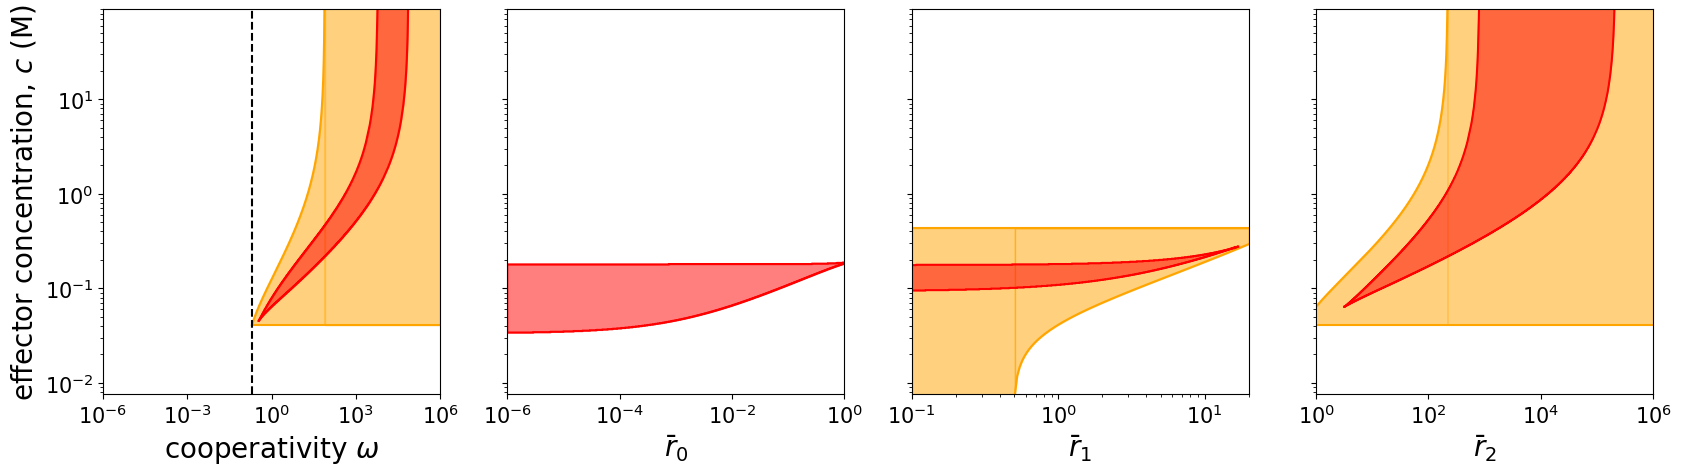

In [34]:
fig, axs = plt.subplots(1,4, sharey=True, figsize=(20, 5))

# omega

w_min_bifurcation = max(4*fixed_r1/ fixed_r2,2*(1+np.exp(-delE))/fixed_r2)
w_min_maximal_concentration_bound_doesnt_exist=2*(1+np.exp(-delE)*K_c**2)/fixed_r2
w_values_Descartes_min =  np.logspace(np.log10(w_min_bifurcation), np.log10(max(w_values)), 100)
I_w_min = np.ones(len(w_values_Descartes_min))
w_values_Descartes_max =  np.logspace(np.log10(w_min_bifurcation), np.log10(w_min_maximal_concentration_bound_doesnt_exist), 1000)[:-3]
I_w_max = np.ones(len(w_values_Descartes_max))
w_2=np.logspace(np.log10(w_min_maximal_concentration_bound_doesnt_exist), np.log10(max(w_values)),100)
I_w_2 = np.ones(len(w_2))

axs[0].plot(w_values_Descartes_min,c_bif_min(K_c, delE, fixed_r1)*I_w_min, linewidth=1.5, color = 'orange')
axs[0].plot(w_values_Descartes_max,c_bif_max(K_c, delE, w_values_Descartes_max, fixed_r2),linewidth=1.5, color = 'orange')
axs[0].fill_between(w_values_Descartes_max,c_bif_min(K_c, delE, fixed_r1)*I_w_max , y2=c_bif_max(K_c, delE, w_values_Descartes_max, fixed_r2), color='orange', alpha=0.5)
axs[0].fill_between(w_2,c_bif_min(K_c, delE, fixed_r1)*I_w_2 , y2=np.nanmax(Cmaxbif_values_sweep_w)*1.3, color='orange', alpha=0.5)

axs[0].plot(w_values, Cminbif_values_sweep_w, linewidth = 1.5, color = 'red')
axs[0].plot(w_values, Cmaxbif_values_sweep_w, linewidth = 1.5, color = 'red')
axs[0].fill_between(w_values, Cminbif_values_sweep_w , y2=Cmaxbif_values_sweep_w, color='red', alpha=0.5)

axs[0].axvline(w_min_bifurcation, linestyle='--', color='k', linewidth=1.5)

axs[0].tick_params(axis='both', which='both', labelsize = size_legend_axis )
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_ylabel(r'effector concentration, $c$ (M)', fontsize = 20)
axs[0].set_xlabel(r'cooperativity $\omega$', fontsize = size_label_axis_x)
axs[0].set_xlim((np.min(w_values), np.max(w_values)))


# r0
axs[1].plot(r0_values, Cmaxbif_values_sweep_r0, linewidth = 1.5, color = 'red')
axs[1].plot(r0_values, Cminbif_values_sweep_r0, linewidth = 1.5, color = 'red')
axs[1].fill_between(r0_values, Cminbif_values_sweep_r0, Cmaxbif_values_sweep_r0, color='red', alpha=0.5)

axs[1].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'$\bar{r}_0$', fontsize = size_label_axis_x)
axs[1].set_xlim((np.min(r0_values), np.max(r0_values)))

# r1

r_1_max_bifurcation=min(fixed_w*fixed_r2/4,(1+np.exp(-delE)*K_c**2)/2)
r_1_max_minimal_concentration_bound_doesnt_exist=(1+np.exp(-delE))/2
r1_values_Descartes_max =  np.logspace(np.log10(min(r1_values)), np.log10(r_1_max_bifurcation), 100)
I_r1_max = np.ones(len(r1_values_Descartes_max))
r1_2 =  np.logspace(np.log10(min(r1_values)), np.log10(r_1_max_minimal_concentration_bound_doesnt_exist), 100)
I_r1_2 = np.ones(len(r1_2))
r1_values_Descartes_min =  np.logspace(np.log10(r_1_max_minimal_concentration_bound_doesnt_exist), np.log10(min(r_1_max_bifurcation,max(r1_values))), 100)
dec=c_bif_min(K_c, delE, r1_values_Descartes_min)

axs[2].plot(r1_values_Descartes_max,c_bif_max(K_c, delE, fixed_w, fixed_r2)*I_r1_max,linewidth=1.5, color = 'orange')
axs[2].plot(r1_values_Descartes_min,dec, linewidth = 1.5, color = 'orange')
axs[2].fill_between(r1_values_Descartes_min,dec, y2=c_bif_max(K_c, delE, fixed_w, fixed_r2)*I_r1_max, color='orange', alpha=0.5)
axs[2].fill_between(r1_2, c_bif_max(K_c, delE, fixed_w, fixed_r2)*I_r1_2, color='orange', alpha=0.5)

axs[2].plot(r1_values, Cmaxbif_values_sweep_r1, linewidth = 1.5, color = 'red')
axs[2].plot(r1_values, Cminbif_values_sweep_r1, linewidth = 1.5, color = 'red')
axs[2].fill_between(r1_values, Cminbif_values_sweep_r1, Cmaxbif_values_sweep_r1, color='red', alpha=0.5)

axs[2].axvline(r_1_max_bifurcation, linestyle='--', color='k', linewidth=1.5)

axs[2].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'$\bar{r}_1$', fontsize = size_label_axis_x)
axs[2].set_xlim((np.min(r1_values), np.max(r1_values)))

# r2

r_2_min_bifurcation=max(4*fixed_r1/ fixed_w,2*(1+np.exp(-delE))/fixed_w)
r_2_min_maximal_concentration_bound_doesnt_exist=2*(1+np.exp(-delE)*K_c**2)/fixed_w
r2_values_Descartes_max =  np.logspace(np.log10(r_2_min_bifurcation), np.log10(r_2_min_maximal_concentration_bound_doesnt_exist), 1000)[:-3]
I_r2_max = np.ones(len(r2_values_Descartes_max))
r2_2 = np.logspace(np.log10(r_2_min_maximal_concentration_bound_doesnt_exist), np.log10(max(r2_values)), 100)
I_r2_2 = np.ones(len(r2_2))

r2_values_Descartes_min =  np.logspace(np.log10(r_2_min_bifurcation), np.log10(max(r2_values)), 100)
I_r2_min = np.ones(len(r2_values_Descartes_min))

axs[3].plot(r2_values_Descartes_min,c_bif_min(K_c, delE, fixed_r1)*I_r2_min, linewidth = 1.5, color = 'orange')
axs[3].plot(r2_values_Descartes_max,c_bif_max(K_c, delE, fixed_w, r2_values_Descartes_max), linewidth=1.5, color = 'orange')
axs[3].fill_between(r2_2,c_bif_min(K_c, delE, fixed_r1)*I_r2_2, y2=np.nanmax(Cmaxbif_values_sweep_w)*1.3, color='orange', alpha=0.5,edgecolor='none')
axs[3].fill_between(r2_values_Descartes_max,c_bif_min(K_c, delE, fixed_r1)*I_r2_max, y2=c_bif_max(K_c, delE, fixed_w, r2_values_Descartes_max),edgecolor='none', color='orange', alpha=0.5)

axs[3].plot(r2_values, Cmaxbif_values_sweep_r2, linewidth = 1.5, color = 'red')
axs[3].plot(r2_values, Cminbif_values_sweep_r2, linewidth = 1.5, color = 'red')
axs[3].fill_between(r2_values, Cminbif_values_sweep_r2, Cmaxbif_values_sweep_r2, color='red', alpha=0.5)

axs[3].axvline(r_2_min_bifurcation, linestyle='--', color='k')

axs[3].tick_params(axis='both', which='major', labelsize = size_legend_axis )
axs[3].set_xscale('log')
axs[3].set_yscale('log')

axs[3].set_xlabel(r'$\bar{r}_2$', fontsize = size_label_axis_x)
axs[3].set_xlim((np.min(r2_values), np.max(r2_values)))
axs[3].set_ylim((np.min(dec), np.nanmax(Cmaxbif_values_sweep_w)*0.9))
plt.show()